In [ ]:
# ATTENTION! Only after import ipem_auditory_model fails, 
# recompile the C file using the code in this cell, and move the files according to the setup comments.
!pip install cython
import cython
%cd C:/Users/w1881/Desktop/github/jlmt_python
!python setup.py build_ext --inplace

In [ ]:
import os
import sys
## Change the path to the package location on your computer.
os.chdir(r"C:\Users\w1881\Desktop\github\jlmt_python")
print(os.getcwd())#Setting up the work environment
sys.path.append(r"C:\Users\w1881\Desktop\github\jlmt_python\src")
sys.path.append(r"C:\Users\w1881\Desktop\github\jlmt_python\src\jlmt_py")#Add the jlmt_py package to the path


C:\Users\w1881\Desktop\github\jlmt_python


In [ ]:
from jlmt_py import load_audio

audio_path = r"C:\Users\w1881\Desktop\github\jlmt_python\test_sound\SchumannKurioseGeschichte.wav"   # Your own music file path


y, sr = load_audio(audio_path)
print(f"Audio loaded: {y.shape}, sample rate: {sr}")

Audio loaded: (121023,), sample rate: 22050


Start of calc_ani...
...end of calc_ani.


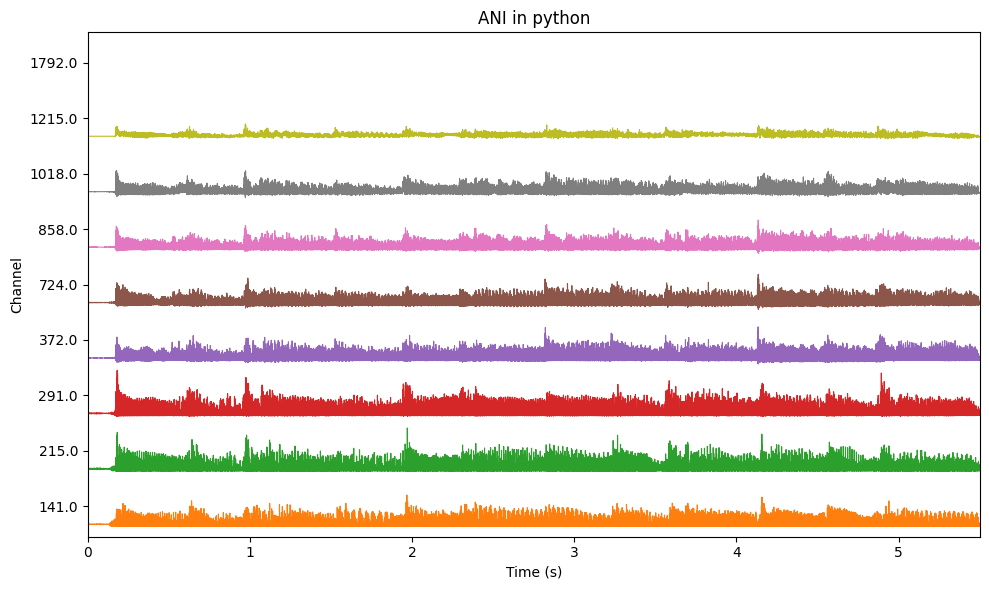

In [4]:
from jlmt_py import calc_ani, plot_multi_channel

ani, ani_freq, freqs = calc_ani(y, sr)
plot_multi_channel(
   ani,
   sample_freq=ani_freq,
   title='ANI in python',
   xlabel='Time (s)',
   ylabel='Channel',
   font_size=12,
   channel_labels=freqs,
   channels=[1, 3, 5, 7, 14, 16, 18, 20, 24],
   plot_type=2
)

In [5]:
from jlmt_py import calc_pp, apply_attenuation
pp, out_fs, out_periods, fani, delay = calc_pp(ani, ani_freq)
final_pp = apply_attenuation(pp, atten_type='ipem_squash_hf')

print(final_pp.shape)


(105, 143)


In [6]:
from jlmt_py import leaky_integrate
li = leaky_integrate(final_pp, out_fs, half_decay_time=0.1)

print(li.shape)

(105, 143)


In [8]:
from jlmt_py import load_som, calc_tonal_space
som_path = "./map/map_10-Dec-2006_16_18.mat"

weights, msize = load_som(som_path)
print("weights shape (n_units, n_features):", weights.shape)
ts_map_3d, ts_map_2d = calc_tonal_space(li, weights, msize)

print(f"3D TS Map shape: {ts_map_3d.shape}")
print(f"2D TS Map shape: {ts_map_2d.shape}")

weights shape (n_units, n_features): (768, 105)
Computing Tonal Space projection...
...Done. TS activation map shape: (24, 32, 143)
3D TS Map shape: (24, 32, 143)
2D TS Map shape: (768, 143)


In [ ]:
#plot tonal space(Modularization was not performed because its correctness was uncertain.)
from matplotlib.animation import FuncAnimation, PillowWriter
import numpy as np
import matplotlib.pyplot as plt

# 1. Define real-time synchronization parameters
n_frames = ts_map_3d.shape[2] 
frame_step_sec = 0.04         
real_time_fps = 1.0 / frame_step_sec  
interval_ms = frame_step_sec * 1000 

print(f"Total frames: {n_frames}")
print(f"Computed FPS: {real_time_fps:.2f} (interval {interval_ms:.1f} ms)")
print(f"Total animation duration: {n_frames * frame_step_sec:.2f} seconds")

# 2. Prepare animation
rows, cols, _ = ts_map_3d.shape
vmin = np.percentile(ts_map_3d, 1)
vmax = np.percentile(ts_map_3d, 99)

fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(ts_map_3d[:, :, 0], cmap='jet', origin='lower', interpolation='bilinear', vmin=vmin, vmax=vmax)

cbar = fig.colorbar(im, ax=ax, label="Activation Value")
ax.set_title(f"Tonal Space Activation - Frame 0 / {n_frames-1}")
ax.set_xlabel("Torus Dimension 1 (Cols)")
ax.set_ylabel("Torus Dimension 2 (Rows)")

# 3. Update function for animation
def update(frame):
    im.set_data(ts_map_3d[:, :, frame])
    ax.set_title(f"Tonal Space Activation - Frame {frame} / {n_frames-1}")
    return (im,) 


In [12]:
import cv2
import numpy as np
output_filename = 'tonal_space_activation_CV2.mp4'
fps = real_time_fps
width = fig.canvas.get_width_height()[0]
height = fig.canvas.get_width_height()[1]

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_filename, fourcc, fps, (width, height))

print(f"Starting to write {n_frames} frames using OpenCV...")


for frame_num in range(n_frames):
    update(frame_num) 
    fig.canvas.draw()

    img_buf = fig.canvas.buffer_rgba()
    img_array = np.frombuffer(img_buf, dtype=np.uint8).reshape((height, width, 4))

    img_bgr = cv2.cvtColor(img_array, cv2.COLOR_RGBA2BGR)

    out.write(img_bgr)

    if frame_num % 100 == 0:
        print(f"Wrote frame {frame_num}...")

out.release()
plt.close(fig)
print(f"OpenCV animation saved as: {output_filename}")

Starting to write 143 frames using OpenCV...
Wrote frame 0...
Wrote frame 100...
OpenCV animation saved as: tonal_space_activation_CV2.mp4
